In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly_express as px
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from scipy.spatial import distance

SEED = 42

In [2]:
projects = pd.read_csv("../data/nrao_projects.csv")
projects = projects.set_index('project_code')

In [3]:
projects.head()

,project_title,project_abstract,fs_type,target,raw_text,standardized_text,no_sw_text,lemmatized_sw_text,lemmatized_no_sw_text
project_code,,,,,,,,,
2018.1.01205.L,Fifty AU STudy of the chemistry in the disk/en...,The huge variety of planetary systems discover...,line,1,Fifty AU STudy of the chemistry in the disk/en...,fifty au study of the chemistry in the disk en...,fifty au study chemistry disk envelope system ...,fifty au study of the chemistry in the disk en...,fifty au study chemistry disk envelope system ...
2022.1.00316.L,COMPASS: Complex Organic Molecules in Protosta...,The emergence of complex organic molecules in ...,line,1,COMPASS: Complex Organic Molecules in Protosta...,compass complex organic molecules in protostar...,compass complex organic molecules protostars s...,compass complex organic molecule in protostars...,compass complex organic molecule protostars sp...
2017.1.00161.L,ALCHEMI: the ALMA Comprehensive High-resolutio...,A great variety in gas composition is observed...,line,1,ALCHEMI: the ALMA Comprehensive High-resolutio...,alchemi the comprehensive high resolution extr...,alchemi comprehensive high resolution extragal...,alchemi the comprehensive high resolution extr...,alchemi comprehensive high resolution extragal...
2021.1.01616.L,ALMA JELLY - Survey of Nearby Jellyfish and Ra...,We propose the first ever statistical survey o...,line,1,ALMA JELLY - Survey of Nearby Jellyfish and Ra...,jelly survey of nearby jellyfish and ram press...,jelly survey nearby jellyfish ram pressure str...,jelly survey of nearby jellyfish and ram press...,jelly survey nearby jellyfish ram pressure str...
2021.1.00869.L,Bulge symmetry or not? The hidden dynamics of ...,A radio survey of red giant SiO sources in the...,line,1,Bulge symmetry or not? The hidden dynamics of ...,bulge symmetry or not the hidden dynamics of t...,bulge symmetry hidden dynamics far side radio ...,bulge symmetry or not the hidden dynamic of th...,bulge symmetry hidden dynamic far side radio s...


In [4]:
line_projects = projects.query('fs_type == "line"')
line_projects.shape

(3628, 9)

In [5]:
measurements = pd.read_csv('../../nrao_measurements.csv')
measurements = measurements.set_index('project_code')

In [6]:
measurements.head()

,project_title,project_abstract,fs_type,low_freq,high_freq,target,diff_freq,med_freq,raw_text,standardized_text,no_sw_text,lemmatized_sw_text,lemmatized_no_sw_text
project_code,,,,,,,,,,,,,
2011.0.00010.S,The Physics and Chemisty of Gas in Centaurus A...,Centaurus A with its host NGC5128 is the most ...,line,90.38,90.62,1,0.24,90.500,The Physics and Chemisty of Gas in Centaurus A...,the physics and chemisty of gas in centaurus a...,physics chemisty gas centaurus host v centauru...,the physic and chemisty of gas in centaurus a ...,physic chemisty gas centaurus host v centaurus...
2011.0.00010.S,The Physics and Chemisty of Gas in Centaurus A...,Centaurus A with its host NGC5128 is the most ...,line,90.70,90.93,1,0.23,90.815,The Physics and Chemisty of Gas in Centaurus A...,the physics and chemisty of gas in centaurus a...,physics chemisty gas centaurus host v centauru...,the physic and chemisty of gas in centaurus a ...,physic chemisty gas centaurus host v centaurus...
2011.0.00010.S,The Physics and Chemisty of Gas in Centaurus A...,Centaurus A with its host NGC5128 is the most ...,line,91.69,91.92,1,0.23,91.805,The Physics and Chemisty of Gas in Centaurus A...,the physics and chemisty of gas in centaurus a...,physics chemisty gas centaurus host v centauru...,the physic and chemisty of gas in centaurus a ...,physic chemisty gas centaurus host v centaurus...
2011.0.00010.S,The Physics and Chemisty of Gas in Centaurus A...,Centaurus A with its host NGC5128 is the most ...,line,92.89,93.12,1,0.23,93.005,The Physics and Chemisty of Gas in Centaurus A...,the physics and chemisty of gas in centaurus a...,physics chemisty gas centaurus host v centauru...,the physic and chemisty of gas in centaurus a ...,physic chemisty gas centaurus host v centaurus...
2011.0.00010.S,The Physics and Chemisty of Gas in Centaurus A...,Centaurus A with its host NGC5128 is the most ...,line,217.59,218.53,1,0.94,218.060,The Physics and Chemisty of Gas in Centaurus A...,the physics and chemisty of gas in centaurus a...,physics chemisty gas centaurus host v centauru...,the physic and chemisty of gas in centaurus a ...,physic chemisty gas centaurus host v centaurus...


## Train-test split

In [7]:
train_texts, test_texts = train_test_split(line_projects.lemmatized_no_sw_text, random_state=SEED)

In [8]:
print(f'Number of train texts:{len(list(train_texts))}')
print(f'Number of test texts:{len(list(test_texts))}')

Number of train texts:2721
Number of test texts:907


In [9]:
train_texts

project_code
2017.1.00065.S    co dark molecular gas extend ultraviolet disk ...
2013.1.00530.S    detailed view star form gas dusty herschel atl...
2016.1.00243.S    confirm deeply embed protostellar population c...
2021.2.00056.S    panta rei mass energy flow parsec sub parsec s...
2021.1.00347.S    trigger supression star formation recent gas r...
                                        ...                        
2015.1.00315.S    secret live badgrs discover nearby population ...
2016.1.00949.S    uncover early formation extremely massive star...
2013.1.00448.S    origin warm water emission low mass protostars...
2023.1.00750.S    hii gas cosmic noon aca survey oiii z aim surv...
2021.2.00140.S    origin rotational motion dense core rotation s...
Name: lemmatized_no_sw_text, Length: 2721, dtype: object

### LDA class

In [10]:
class LDA_Model:
    def __init__(self, N_topics=3):
        self.N_topics = N_topics
        self.countVectorizer = CountVectorizer(stop_words='english')
        self.lda = LatentDirichletAllocation(n_components=self.N_topics, random_state=SEED)
    
    def fit(self, corpus):
        termFrequency = self.countVectorizer.fit_transform(corpus)
        self.lda.fit(termFrequency)
        return self.lda.transform(termFrequency)

    # Additional method to transform new data
    def transform(self, corpus):
        termFrequency = self.countVectorizer.transform(corpus)
        return self.lda.transform(termFrequency)

#### Initialize Model

In [11]:
lda_model = LDA_Model(N_topics=50)

#### Fit model on training set

In [12]:
train_topics = lda_model.fit(train_texts)

In [13]:
words = lda_model.countVectorizer.get_feature_names_out()

In [14]:
N = 10 #number of top words to show
topic_components = lda_model.lda.components_

for topic_idx, topic in enumerate(topic_components):
    print(f"Topic {topic_idx}:")
    # Get the indices of the top N words for this topic
    top_word_indices = topic.argsort()[-N:][::-1]
    # Print these words with their weights
    for word_idx in top_word_indices:
        print(f"{words[word_idx]} (weight: {topic[word_idx]:.2f})")
    print("\n")

Topic 0:
mass (weight: 881.54)
star (weight: 641.64)
high (weight: 470.45)
massive (weight: 266.84)
formation (weight: 259.51)
form (weight: 206.35)
binary (weight: 192.54)
observation (weight: 156.71)
low (weight: 153.11)
stellar (weight: 146.04)


Topic 1:
spt (weight: 21.93)
south (weight: 19.32)
model (weight: 18.50)
star (weight: 16.23)
molecular (weight: 15.83)
exo (weight: 15.02)
pole (weight: 13.98)
type (weight: 11.96)
herschel (weight: 11.40)
telescope (weight: 10.91)


Topic 2:
emission (weight: 155.31)
ngc (weight: 121.67)
maser (weight: 97.24)
sio (weight: 95.55)
region (weight: 92.04)
pc (weight: 88.97)
ghz (weight: 86.85)
disk (weight: 83.92)
torus (weight: 76.15)
resolution (weight: 74.02)


Topic 3:
gas (weight: 149.49)
observation (weight: 76.83)
disk (weight: 68.48)
star (weight: 51.89)
resolution (weight: 49.05)
dust (weight: 45.13)
compact (weight: 44.32)
region (weight: 41.86)
study (weight: 31.07)
form (weight: 30.96)


Topic 4:
star (weight: 68.54)
band (weight:

In [15]:
train_doc_topic = pd.DataFrame(train_topics)
train_doc_topic = train_doc_topic.set_index(train_texts.index.values)
train_doc_topic.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
2017.1.00065.S,0.000182,0.000182,0.000182,0.182190,0.000182,0.112370,0.000182,0.000182,0.055927,0.000182,...,0.000182,0.000182,0.000182,0.204059,0.000182,0.000182,0.000182,0.000182,0.000182,0.000182
2013.1.00530.S,0.000488,0.000488,0.000488,0.000488,0.000488,0.000488,0.000488,0.000488,0.000488,0.000488,...,0.000488,0.000488,0.000488,0.000488,0.000488,0.000488,0.000488,0.000488,0.000488,0.279075
2016.1.00243.S,0.000168,0.000168,0.000168,0.000168,0.000168,0.229194,0.000168,0.032888,0.000168,0.153149,...,0.124602,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.047912,0.000168
2021.2.00056.S,0.990485,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,...,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194
2021.1.00347.S,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,...,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163


In [16]:
train_texts = pd.DataFrame(train_texts)

### Match test data into topics

In [17]:
test_topics = lda_model.transform(test_texts)

In [18]:
test_doc_topic= pd.DataFrame(test_topics.tolist())
test_doc_topic= test_doc_topic.set_index(test_texts.index.values)
test_doc_topic.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
2015.1.01599.S,0.000227,0.000227,0.000227,0.000227,0.000227,0.000227,0.000227,0.000227,0.000227,0.000227,...,0.000227,0.024465,0.000227,0.000227,0.000227,0.000227,0.000227,0.000227,0.000227,0.000227
2017.1.01119.S,0.000217,0.000217,0.000217,0.000217,0.000217,0.000217,0.000217,0.000217,0.000217,0.000217,...,0.000217,0.000217,0.000217,0.228499,0.000217,0.046176,0.097682,0.000217,0.000217,0.000217
2018.1.01172.S,0.000278,0.000278,0.000278,0.000278,0.082816,0.000278,0.000278,0.000278,0.643607,0.025516,...,0.000278,0.000278,0.000278,0.000278,0.000278,0.000278,0.000278,0.000278,0.000278,0.000278
2022.1.00181.S,0.000185,0.000185,0.000185,0.000185,0.000185,0.102403,0.073797,0.000185,0.128958,0.000185,...,0.000185,0.000185,0.000185,0.000185,0.022959,0.000185,0.000185,0.000185,0.000185,0.000185
2019.2.00190.S,0.000174,0.000174,0.000174,0.000174,0.000174,0.017219,0.000174,0.126316,0.000174,0.000174,...,0.000174,0.000174,0.000174,0.000174,0.000174,0.147459,0.000174,0.000174,0.000174,0.000174


In [19]:
test_texts = pd.DataFrame(test_texts)

## Try comparing two projects based on topic vector similarity using dot product

In [20]:
comp = np.dot(train_doc_topic, test_doc_topic.iloc[1].T)

In [21]:
train_doc_topic.iloc[comp.argmax()].name

'2022.1.00554.S'

In [22]:
comp_frame = pd.DataFrame(comp)\
    .set_index(train_texts.index.values)
comp_frame.columns = ['dot_product_similarity']
comp_frame = comp_frame.sort_values('dot_product_similarity', ascending=False)

In [23]:
comp_frame.shape

(2721, 1)

In [24]:
comp_frame.describe()

,dot_product_similarity
count,2721.000000
mean,0.034312
std,0.046425
min,0.000283
25%,0.000411
50%,0.010148
75%,0.057169
max,0.239695


In [25]:
comp_frame.dot_product_similarity.quantile(q=0.75)

0.05716905205709218

In [26]:
comp_frame.head()

,dot_product_similarity
2022.1.00554.S,0.239695
2016.1.00297.S,0.232959
2023.1.00737.S,0.229503
2013.1.00940.S,0.228979
2017.1.01174.S,0.228913


In [27]:
q4_comp = comp_frame[comp_frame.dot_product_similarity > comp_frame.dot_product_similarity.quantile(q=0.999)]
q4_comp

,dot_product_similarity
2022.1.00554.S,0.239695
2016.1.00297.S,0.232959
2023.1.00737.S,0.229503


In [28]:
px.histogram(q4_comp.dot_product_similarity)

In [29]:
train_texts.iloc[1896]

lemmatized_no_sw_text    smc b new perseus relationship av co low metal...
Name: 2015.1.01125.S, dtype: object

In [30]:
test_texts.iloc[0]

lemmatized_no_sw_text    remote detection organic enceladus plume encel...
Name: 2015.1.01599.S, dtype: object

In [31]:
fig = px.scatter(measurements.loc[list(q4_comp.index.values)].med_freq)
#fig.add_trace(px.scatter(measurements.loc['2017.1.01247.S'].med_freq).data[0])
fig

## Loop over test points and find differences between frequency setup for test point and top (ties not resolved...maybe use most recent?) dot product similarity project 

In [32]:
proj_measurements = measurements.query('fs_type == "line"')[['low_freq', 'high_freq', 'diff_freq', 'med_freq']]
proj_measurements = proj_measurements.groupby(proj_measurements.index).agg({
    'low_freq':lambda x: round(x, 4).tolist(),
    'high_freq':lambda x: round(x, 4).tolist(),
    'diff_freq':lambda x: round(x, 4).tolist(),
    'med_freq':lambda x: round(x, 4).tolist()
})
proj_measurements

,low_freq,high_freq,diff_freq,med_freq
project_code,,,,
2011.0.00010.S,"[90.38, 90.7, 91.69, 92.89, 217.59, 218.67, 21...","[90.62, 90.93, 91.92, 93.12, 218.53, 219.6, 21...","[0.24, 0.23, 0.23, 0.23, 0.94, 0.93, 0.94, 0.9...","[90.5, 90.815, 91.805, 93.005, 218.06, 219.135..."
2011.0.00017.S,"[87.72, 89.54, 99.72, 101.54, 91.37, 93.19, 10...","[89.6, 91.42, 101.59, 103.42, 93.24, 95.07, 10...","[1.88, 1.88, 1.87, 1.88, 1.87, 1.88, 1.88, 1.8...","[88.66, 90.48, 100.655, 102.48, 92.305, 94.13,..."
2011.0.00020.S,"[334.61, 346.72, 328.56, 330.44, 340.63, 342.3...","[336.5, 348.61, 330.44, 332.32, 342.51, 344.27...","[1.89, 1.89, 1.88, 1.88, 1.88, 1.88, 1.92, 1.9...","[335.555, 347.665, 329.5, 331.38, 341.57, 343...."
2011.0.00028.S,"[342.36, 344.24, 354.28, 355.79, 342.36]","[344.23, 346.11, 356.16, 357.66, 344.24]","[1.87, 1.87, 1.88, 1.87, 1.88]","[343.295, 345.175, 355.22, 356.725, 343.3]"
2011.0.00039.S,"[338.32, 340.18, 350.37, 352.2]","[340.2, 342.06, 352.24, 354.08]","[1.88, 1.88, 1.87, 1.88]","[339.26, 341.12, 351.305, 353.14]"
...,...,...,...,...
2023.1.01710.S,"[105.15, 103.52, 103.38]","[106.09, 104.45, 104.32]","[0.94, 0.93, 0.94]","[105.62, 103.985, 103.85]"
2023.1.01720.S,"[216.99, 217.88, 220.28, 220.88, 231.56, 234.06]","[217.22, 218.12, 220.52, 221.12, 233.44, 235.94]","[0.23, 0.24, 0.24, 0.24, 1.88, 1.88]","[217.105, 218.0, 220.4, 221.0, 232.5, 235.0]"
2023.1.01721.S,"[340.64, 342.52, 352.66, 354.53]","[342.52, 344.39, 354.54, 356.41]","[1.88, 1.87, 1.88, 1.88]","[341.58, 343.455, 353.6, 355.47]"


In [33]:
proj_measurements.low_freq = proj_measurements.low_freq.apply(lambda x: sorted(x))
proj_measurements.high_freq = proj_measurements.high_freq.apply(lambda x: sorted(x))

In [34]:
proj_measurements.head()

,low_freq,high_freq,diff_freq,med_freq
project_code,,,,
2011.0.00010.S,"[85.96, 87.05, 87.47, 87.65, 88.36, 88.91, 90....","[86.19, 87.29, 87.7, 87.88, 88.59, 89.15, 90.6...","[0.24, 0.23, 0.23, 0.23, 0.94, 0.93, 0.94, 0.9...","[90.5, 90.815, 91.805, 93.005, 218.06, 219.135..."
2011.0.00017.S,"[84.09, 85.9, 87.72, 89.54, 91.37, 93.19, 95.0...","[85.97, 87.78, 89.6, 91.42, 93.24, 95.07, 96.9...","[1.88, 1.88, 1.87, 1.88, 1.87, 1.88, 1.88, 1.8...","[88.66, 90.48, 100.655, 102.48, 92.305, 94.13,..."
2011.0.00020.S,"[251.53, 253.41, 257.24, 266.22, 267.87, 272.3...","[253.42, 255.29, 259.13, 268.11, 269.75, 274.2...","[1.89, 1.89, 1.88, 1.88, 1.88, 1.88, 1.92, 1.9...","[335.555, 347.665, 329.5, 331.38, 341.57, 343...."
2011.0.00028.S,"[342.36, 342.36, 344.24, 354.28, 355.79]","[344.23, 344.24, 346.11, 356.16, 357.66]","[1.87, 1.87, 1.88, 1.87, 1.88]","[343.295, 345.175, 355.22, 356.725, 343.3]"
2011.0.00039.S,"[338.32, 340.18, 350.37, 352.2]","[340.2, 342.06, 352.24, 354.08]","[1.88, 1.88, 1.87, 1.88]","[339.26, 341.12, 351.305, 353.14]"


Create zipped columns

In [35]:
proj_measurements['lh_freq'] = proj_measurements.apply(lambda x: list(zip(x.low_freq, x.high_freq)), axis=1)
proj_measurements['dm_freq'] = proj_measurements.apply(lambda x: list(zip(x.diff_freq, x.med_freq)), axis=1)

In [36]:
proj_measurements.head()

,low_freq,high_freq,diff_freq,med_freq,lh_freq,dm_freq
project_code,,,,,,
2011.0.00010.S,"[85.96, 87.05, 87.47, 87.65, 88.36, 88.91, 90....","[86.19, 87.29, 87.7, 87.88, 88.59, 89.15, 90.6...","[0.24, 0.23, 0.23, 0.23, 0.94, 0.93, 0.94, 0.9...","[90.5, 90.815, 91.805, 93.005, 218.06, 219.135...","[(85.96, 86.19), (87.05, 87.29), (87.47, 87.7)...","[(0.24, 90.5), (0.23, 90.815), (0.23, 91.805),..."
2011.0.00017.S,"[84.09, 85.9, 87.72, 89.54, 91.37, 93.19, 95.0...","[85.97, 87.78, 89.6, 91.42, 93.24, 95.07, 96.9...","[1.88, 1.88, 1.87, 1.88, 1.87, 1.88, 1.88, 1.8...","[88.66, 90.48, 100.655, 102.48, 92.305, 94.13,...","[(84.09, 85.97), (85.9, 87.78), (87.72, 89.6),...","[(1.88, 88.66), (1.88, 90.48), (1.87, 100.655)..."
2011.0.00020.S,"[251.53, 253.41, 257.24, 266.22, 267.87, 272.3...","[253.42, 255.29, 259.13, 268.11, 269.75, 274.2...","[1.89, 1.89, 1.88, 1.88, 1.88, 1.88, 1.92, 1.9...","[335.555, 347.665, 329.5, 331.38, 341.57, 343....","[(251.53, 253.42), (253.41, 255.29), (257.24, ...","[(1.89, 335.555), (1.89, 347.665), (1.88, 329...."
2011.0.00028.S,"[342.36, 342.36, 344.24, 354.28, 355.79]","[344.23, 344.24, 346.11, 356.16, 357.66]","[1.87, 1.87, 1.88, 1.87, 1.88]","[343.295, 345.175, 355.22, 356.725, 343.3]","[(342.36, 344.23), (342.36, 344.24), (344.24, ...","[(1.87, 343.295), (1.87, 345.175), (1.88, 355...."
2011.0.00039.S,"[338.32, 340.18, 350.37, 352.2]","[340.2, 342.06, 352.24, 354.08]","[1.88, 1.88, 1.87, 1.88]","[339.26, 341.12, 351.305, 353.14]","[(338.32, 340.2), (340.18, 342.06), (350.37, 3...","[(1.88, 339.26), (1.88, 341.12), (1.87, 351.30..."


In [37]:
best_matches = {}
for proj in test_doc_topic.index.values:
    dot_product = np.dot(train_doc_topic, test_doc_topic.loc[proj].T)
    best_matches[proj] = train_doc_topic.iloc[dot_product.argmax()].name

In [38]:
best_matches_frame = pd.DataFrame.from_dict(best_matches, orient='index')
best_matches_frame.columns = ['best_match']
best_matches_frame = best_matches_frame.reset_index()
best_matches_frame = best_matches_frame.set_index('index')
best_matches_frame.index = best_matches_frame.index.rename('test_project')
best_matches_frame.head()

,best_match
test_project,
2015.1.01599.S,2016.1.01543.S
2017.1.01119.S,2022.1.00554.S
2018.1.01172.S,2016.1.00187.S
2022.1.00181.S,2017.1.00815.S
2019.2.00190.S,2019.1.00245.S


In [39]:
best_matches_frame.describe()

,best_match
count,907
unique,62
top,2017.1.00815.S
freq,143


In [40]:
best_matches_frame.value_counts().describe()

count     62.000000
mean      14.629032
std       26.100835
min        1.000000
25%        1.250000
50%        5.000000
75%       15.500000
max      143.000000
Name: count, dtype: float64

In [41]:
train_doc_topic.loc['2017.1.00815.S']

0     0.000192
1     0.000192
2     0.000192
3     0.000192
4     0.000192
5     0.000192
6     0.000192
7     0.000192
8     0.000192
9     0.000192
10    0.000192
11    0.000192
12    0.000192
13    0.000192
14    0.000192
15    0.000192
16    0.000192
17    0.000192
18    0.000192
19    0.000192
20    0.000192
21    0.000192
22    0.000192
23    0.000192
24    0.000192
25    0.000192
26    0.000192
27    0.000192
28    0.000192
29    0.000192
30    0.000192
31    0.000192
32    0.000192
33    0.000192
34    0.990577
35    0.000192
36    0.000192
37    0.000192
38    0.000192
39    0.000192
40    0.000192
41    0.000192
42    0.000192
43    0.000192
44    0.000192
45    0.000192
46    0.000192
47    0.000192
48    0.000192
49    0.000192
Name: 2017.1.00815.S, dtype: float64

In [42]:
best_matches_frame[best_matches_frame.best_match == '2017.1.00815.S']

,best_match
test_project,
2022.1.00181.S,2017.1.00815.S
2017.1.00392.S,2017.1.00815.S
2018.1.01530.S,2017.1.00815.S
2016.1.00121.S,2017.1.00815.S
2017.1.00856.S,2017.1.00815.S
...,...
2015.1.00978.S,2017.1.00815.S
2019.1.01186.S,2017.1.00815.S
2012.1.01000.S,2017.1.00815.S


## Compare best match frequency setups

In [43]:
def find_common_elements(list1, list2) -> list:
    set1 = set(list1)
    set2 = set(list2)
    
    return list(set1.intersection(set2))

In [44]:
def compare_matches(matches_frame:pd.DataFrame, comp_column:str, round:int) -> list:
    percent_test_match_list = []
    for test_proj in matches_frame.index:
        match_proj = matches_frame.loc[test_proj].best_match
        test_measurements = np.round(proj_measurements.loc[test_proj][comp_column], round)
        match_measurements = np.round(proj_measurements.loc[match_proj][comp_column], round)
        common_elements = find_common_elements(test_measurements, match_measurements)
        percent_test_match = len(common_elements)/len(test_measurements)
        percent_test_match_list.append(percent_test_match)
        print(f'Test project {test_proj} compared to best match {match_proj}')
        print(f'len(matched measurements)/len(test measurements) = {percent_test_match}')
    return percent_test_match_list

In [45]:
np.mean(compare_matches(best_matches_frame, 'med_freq', 0))

Test project 2015.1.01599.S compared to best match 2016.1.01543.S
len(matched measurements)/len(test measurements) = 0.0
Test project 2017.1.01119.S compared to best match 2022.1.00554.S
len(matched measurements)/len(test measurements) = 0.0
Test project 2018.1.01172.S compared to best match 2016.1.00187.S
len(matched measurements)/len(test measurements) = 0.0
Test project 2022.1.00181.S compared to best match 2017.1.00815.S
len(matched measurements)/len(test measurements) = 0.0
Test project 2019.2.00190.S compared to best match 2019.1.00245.S
len(matched measurements)/len(test measurements) = 0.0
Test project 2019.A.00019.S compared to best match 2016.1.00978.S
len(matched measurements)/len(test measurements) = 0.0
Test project 2015.1.01199.S compared to best match 2013.1.01166.S
len(matched measurements)/len(test measurements) = 0.0
Test project 2018.1.01506.S compared to best match 2017.1.00082.S
len(matched measurements)/len(test measurements) = 0.0
Test project 2013.1.00663.S comp

0.07037971520475375

## Try comparing documents to documents in top matched topic

### Group documents to highest matching topic

Combine project topic vector frames

In [46]:
proj_topics = pd.concat([train_doc_topic, test_doc_topic])
proj_topics

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
2017.1.00065.S,0.000182,0.000182,0.000182,0.182190,0.000182,0.112370,0.000182,0.000182,0.055927,0.000182,...,0.000182,0.000182,0.000182,0.204059,0.000182,0.000182,0.000182,0.000182,0.000182,0.000182
2013.1.00530.S,0.000488,0.000488,0.000488,0.000488,0.000488,0.000488,0.000488,0.000488,0.000488,0.000488,...,0.000488,0.000488,0.000488,0.000488,0.000488,0.000488,0.000488,0.000488,0.000488,0.279075
2016.1.00243.S,0.000168,0.000168,0.000168,0.000168,0.000168,0.229194,0.000168,0.032888,0.000168,0.153149,...,0.124602,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.000168,0.047912,0.000168
2021.2.00056.S,0.990485,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,...,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194,0.000194
2021.1.00347.S,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,...,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163,0.000163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017.1.01568.S,0.000172,0.000172,0.000172,0.000172,0.000172,0.000172,0.093731,0.000172,0.000172,0.000172,...,0.000172,0.000172,0.000172,0.098483,0.195318,0.000172,0.000172,0.000172,0.000172,0.000172
2021.1.00520.S,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,...,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.000230,0.136610,0.000230
2016.1.01135.S,0.000179,0.000179,0.000179,0.000179,0.000179,0.000179,0.036463,0.000179,0.000179,0.000179,...,0.000179,0.000179,0.000179,0.000179,0.000179,0.098962,0.000179,0.000179,0.000179,0.000179
2018.1.00452.S,0.000220,0.000220,0.031259,0.019243,0.000220,0.020356,0.000220,0.000220,0.042948,0.000220,...,0.000220,0.041414,0.016834,0.000220,0.000220,0.000220,0.000220,0.000220,0.000220,0.000220


Take highest matching topic for each project

In [47]:
proj_topics['max_topic'] = proj_topics.apply(lambda x: x.argmax(), axis=1)

Create data frame with project id and max topic

In [48]:
proj_max_topic = proj_topics['max_topic'].to_frame()
proj_max_topic

,max_topic
2017.1.00065.S,34
2013.1.00530.S,36
2016.1.00243.S,34
2021.2.00056.S,0
2021.1.00347.S,23
...,...
2017.1.01568.S,36
2021.1.00520.S,24
2016.1.01135.S,11
2018.1.00452.S,37


Inspect distribution of max topic

In [49]:
proj_max_topic.value_counts().describe()

count     50.000000
mean      72.560000
std       88.117537
min        6.000000
25%       21.000000
50%       49.000000
75%       86.000000
max      452.000000
Name: count, dtype: float64

There are a few topics that match to a large number of documents

Append project max topic to measurements for ease of grouping documents

In [50]:
proj_measurements = proj_measurements.join(proj_max_topic, how='left')
proj_measurements

,low_freq,high_freq,diff_freq,med_freq,lh_freq,dm_freq,max_topic
project_code,,,,,,,
2011.0.00010.S,"[85.96, 87.05, 87.47, 87.65, 88.36, 88.91, 90....","[86.19, 87.29, 87.7, 87.88, 88.59, 89.15, 90.6...","[0.24, 0.23, 0.23, 0.23, 0.94, 0.93, 0.94, 0.9...","[90.5, 90.815, 91.805, 93.005, 218.06, 219.135...","[(85.96, 86.19), (87.05, 87.29), (87.47, 87.7)...","[(0.24, 90.5), (0.23, 90.815), (0.23, 91.805),...",43
2011.0.00017.S,"[84.09, 85.9, 87.72, 89.54, 91.37, 93.19, 95.0...","[85.97, 87.78, 89.6, 91.42, 93.24, 95.07, 96.9...","[1.88, 1.88, 1.87, 1.88, 1.87, 1.88, 1.88, 1.8...","[88.66, 90.48, 100.655, 102.48, 92.305, 94.13,...","[(84.09, 85.97), (85.9, 87.78), (87.72, 89.6),...","[(1.88, 88.66), (1.88, 90.48), (1.87, 100.655)...",37
2011.0.00020.S,"[251.53, 253.41, 257.24, 266.22, 267.87, 272.3...","[253.42, 255.29, 259.13, 268.11, 269.75, 274.2...","[1.89, 1.89, 1.88, 1.88, 1.88, 1.88, 1.92, 1.9...","[335.555, 347.665, 329.5, 331.38, 341.57, 343....","[(251.53, 253.42), (253.41, 255.29), (257.24, ...","[(1.89, 335.555), (1.89, 347.665), (1.88, 329....",46
2011.0.00028.S,"[342.36, 342.36, 344.24, 354.28, 355.79]","[344.23, 344.24, 346.11, 356.16, 357.66]","[1.87, 1.87, 1.88, 1.87, 1.88]","[343.295, 345.175, 355.22, 356.725, 343.3]","[(342.36, 344.23), (342.36, 344.24), (344.24, ...","[(1.87, 343.295), (1.87, 345.175), (1.88, 355....",3
2011.0.00039.S,"[338.32, 340.18, 350.37, 352.2]","[340.2, 342.06, 352.24, 354.08]","[1.88, 1.88, 1.87, 1.88]","[339.26, 341.12, 351.305, 353.14]","[(338.32, 340.2), (340.18, 342.06), (350.37, 3...","[(1.88, 339.26), (1.88, 341.12), (1.87, 351.30...",35
...,...,...,...,...,...,...,...
2023.1.01710.S,"[103.38, 103.52, 105.15]","[104.32, 104.45, 106.09]","[0.94, 0.93, 0.94]","[105.62, 103.985, 103.85]","[(103.38, 104.32), (103.52, 104.45), (105.15, ...","[(0.94, 105.62), (0.93, 103.985), (0.94, 103.85)]",36
2023.1.01720.S,"[216.99, 217.88, 220.28, 220.88, 231.56, 234.06]","[217.22, 218.12, 220.52, 221.12, 233.44, 235.94]","[0.23, 0.24, 0.24, 0.24, 1.88, 1.88]","[217.105, 218.0, 220.4, 221.0, 232.5, 235.0]","[(216.99, 217.22), (217.88, 218.12), (220.28, ...","[(0.23, 217.105), (0.24, 218.0), (0.24, 220.4)...",5
2023.1.01721.S,"[340.64, 342.52, 352.66, 354.53]","[342.52, 344.39, 354.54, 356.41]","[1.88, 1.87, 1.88, 1.88]","[341.58, 343.455, 353.6, 355.47]","[(340.64, 342.52), (342.52, 344.39), (352.66, ...","[(1.88, 341.58), (1.87, 343.455), (1.88, 353.6...",0


Check it worked

In [51]:
proj_max_topic.loc[['2011.0.00010.S', '2011.0.00017.S', '2023.A.00009.S']]

,max_topic
2011.0.00010.S,43
2011.0.00017.S,37
2023.A.00009.S,14


Eyeball comparison of documents by max topic

In [52]:
proj_max_topic[proj_max_topic.max_topic == 3]

,max_topic
2011.0.00028.S,3
2015.1.00149.S,3
2021.1.01291.S,3
2015.1.00725.S,3
2019.1.00454.S,3
2021.1.00377.S,3
2017.1.00877.S,3
2016.1.01573.S,3
2018.A.00023.S,3
2018.1.01237.S,3


Plot frequency setups for these projects

/var/folders/vx/9pb2fpkj3m5bkbwxzyx6sz5m0000gn/T/ipykernel_37895/1657025061.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



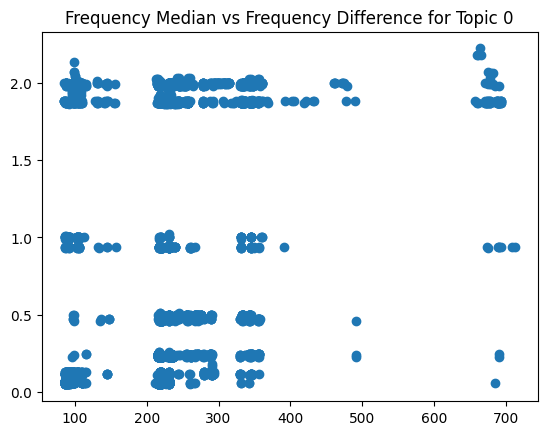

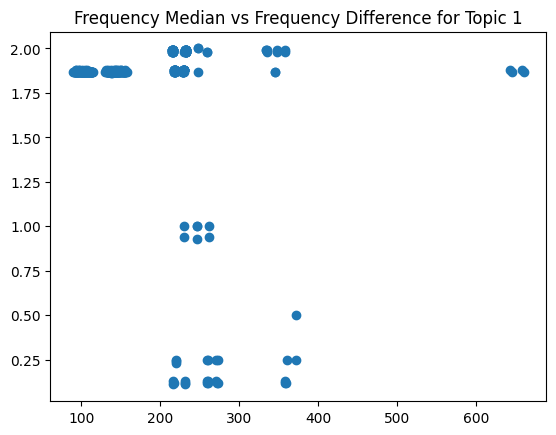

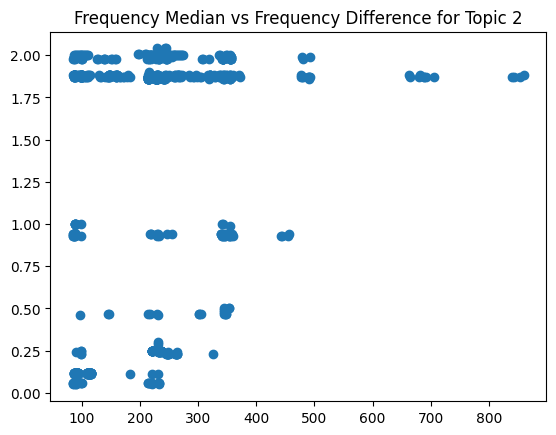

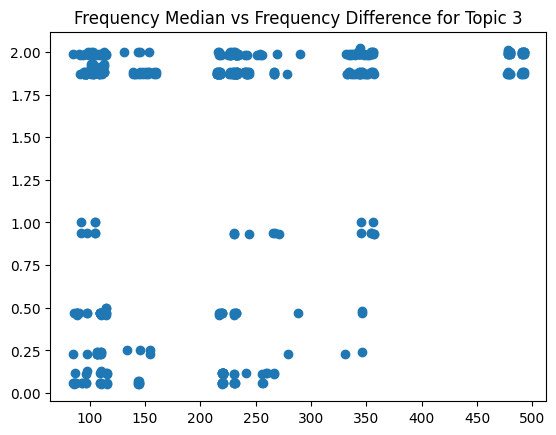

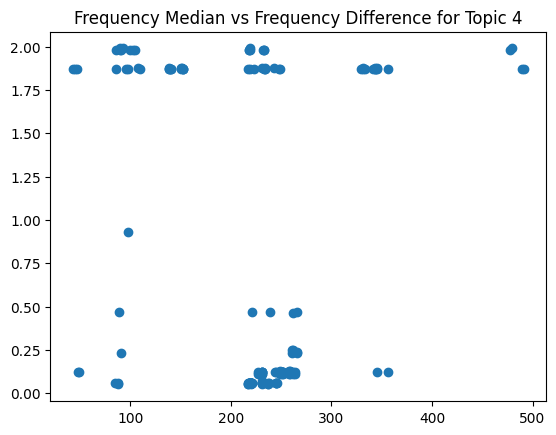

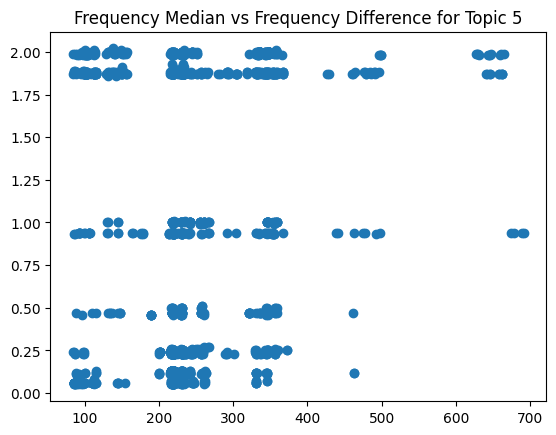

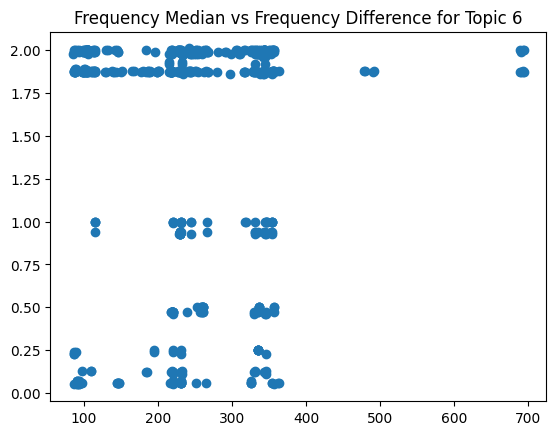

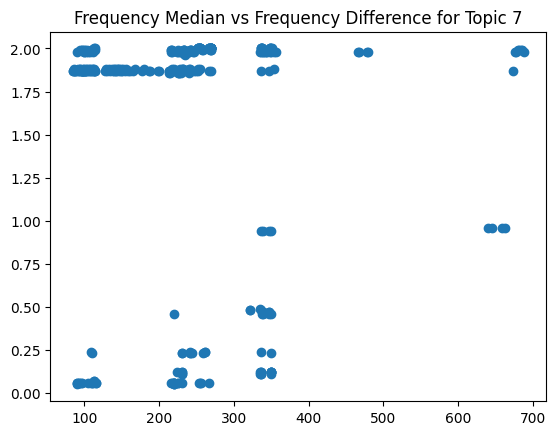

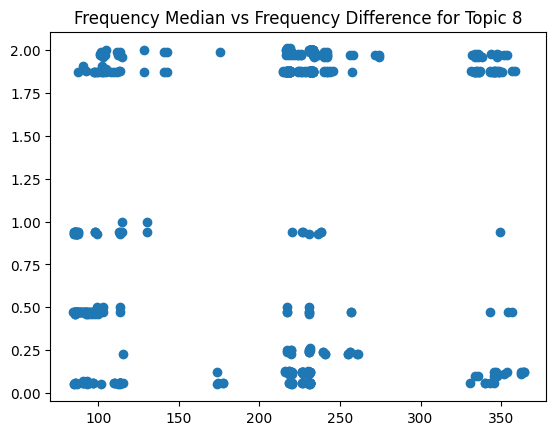

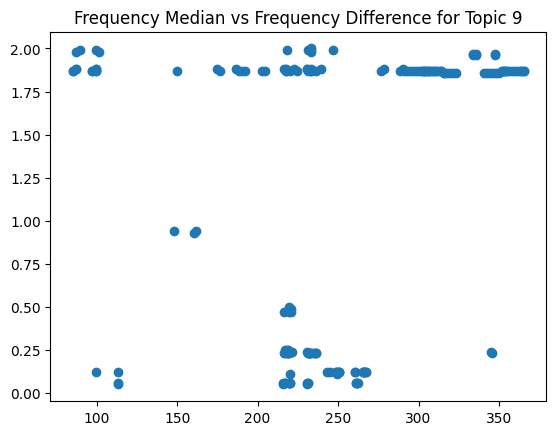

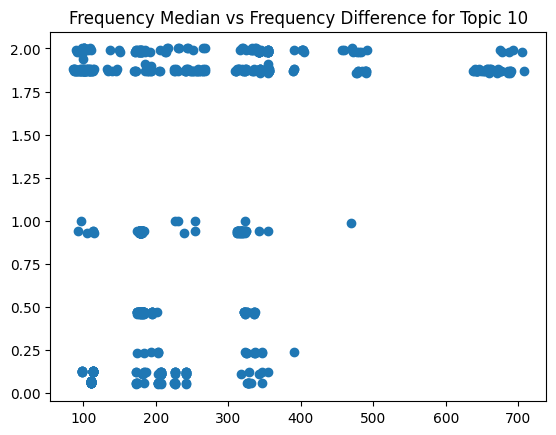

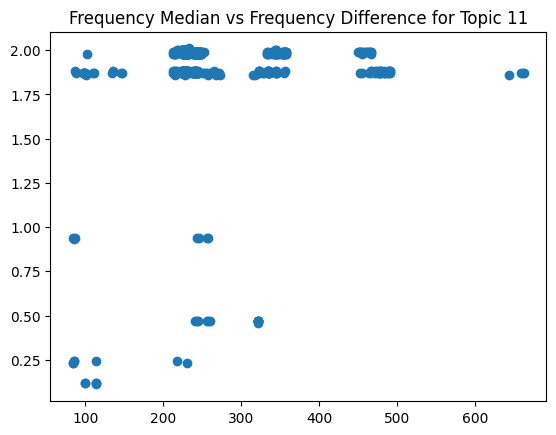

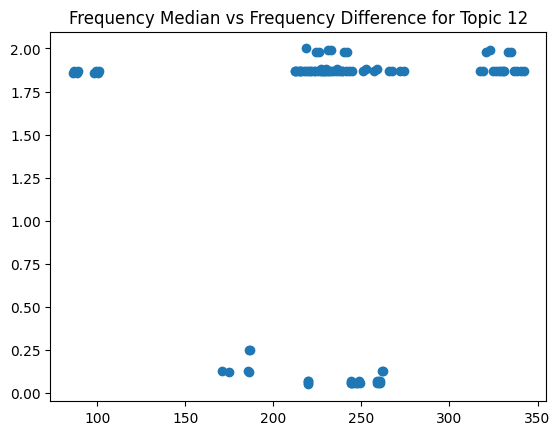

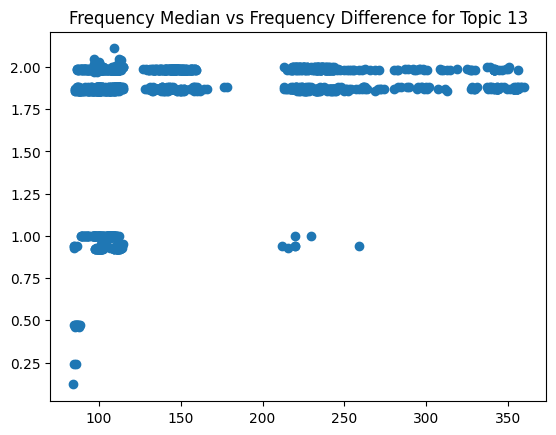

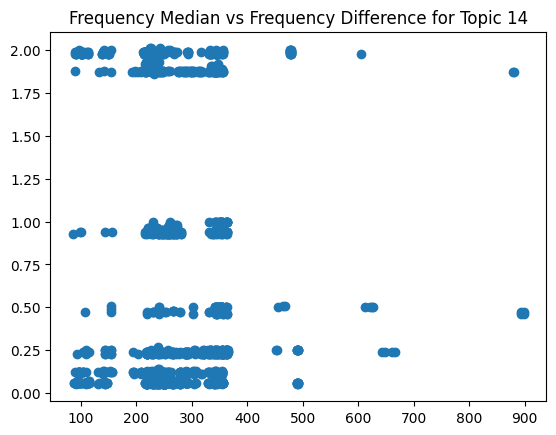

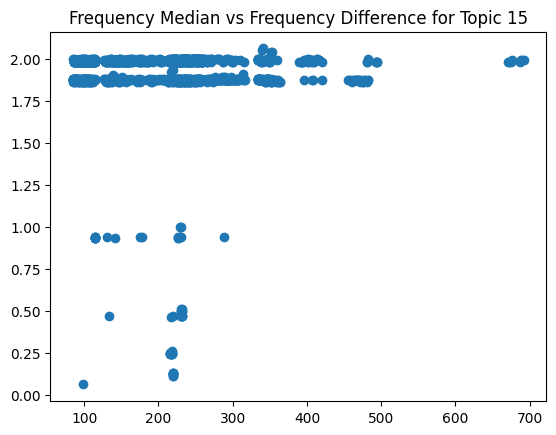

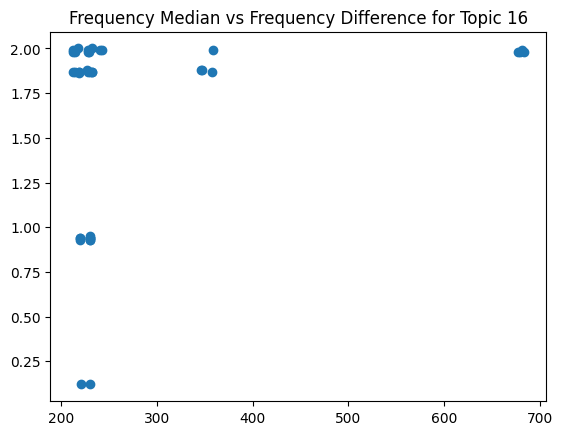

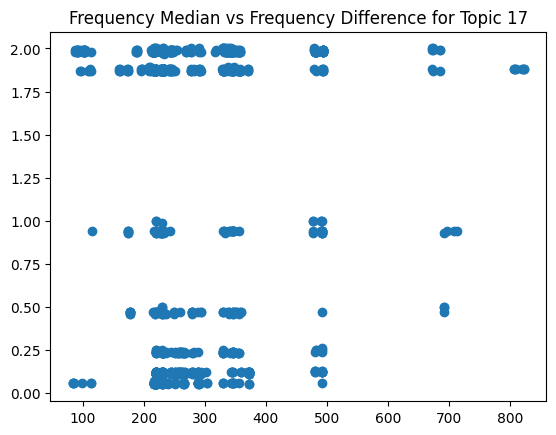

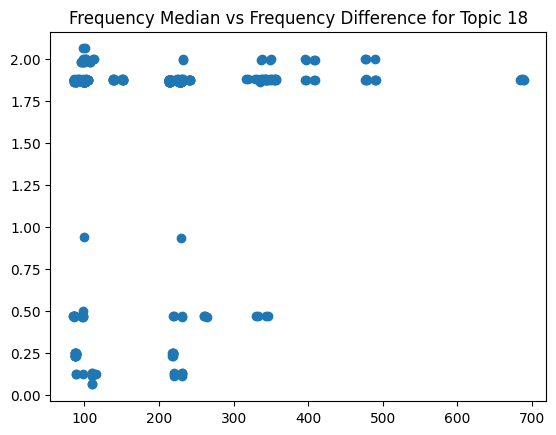

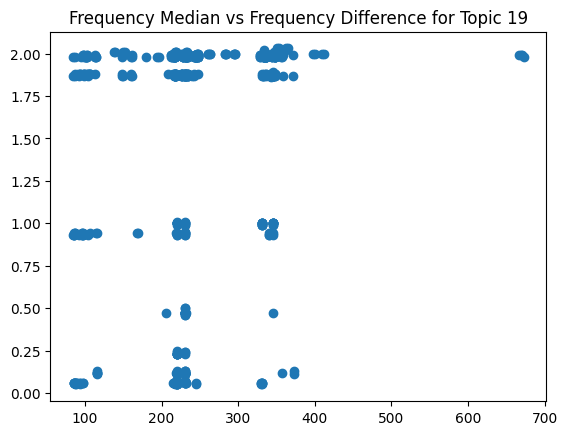

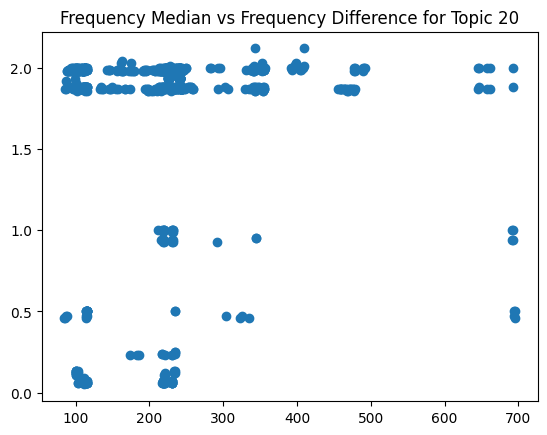

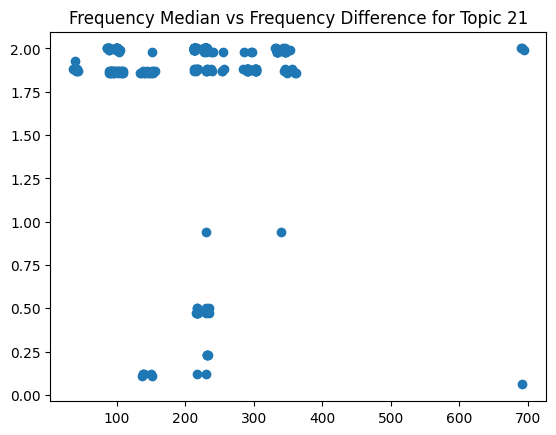

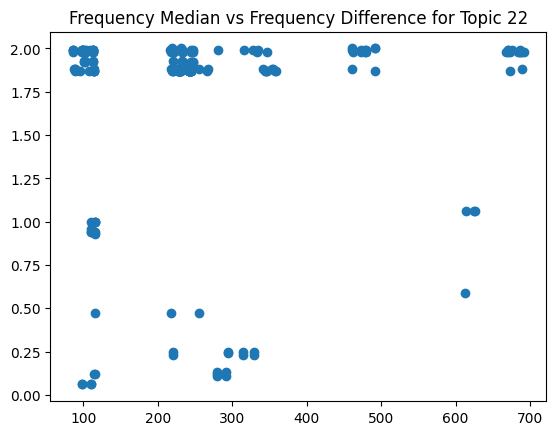

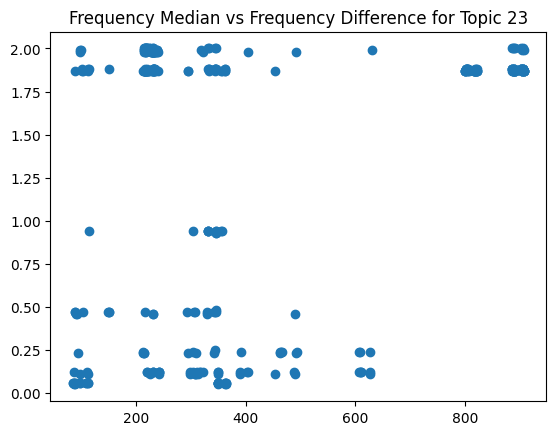

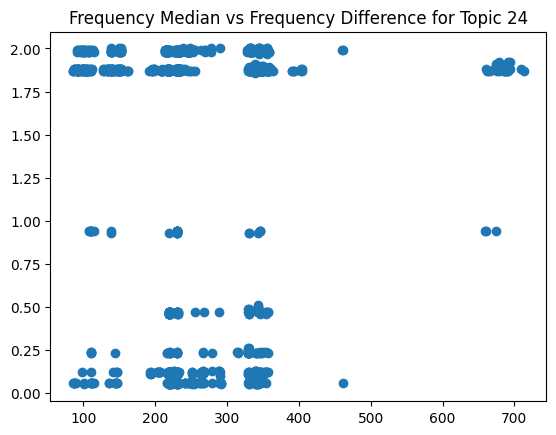

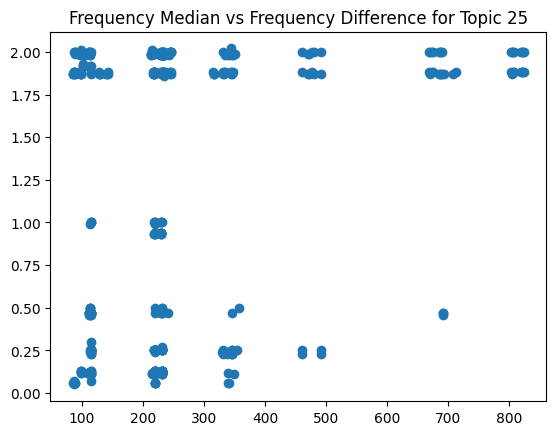

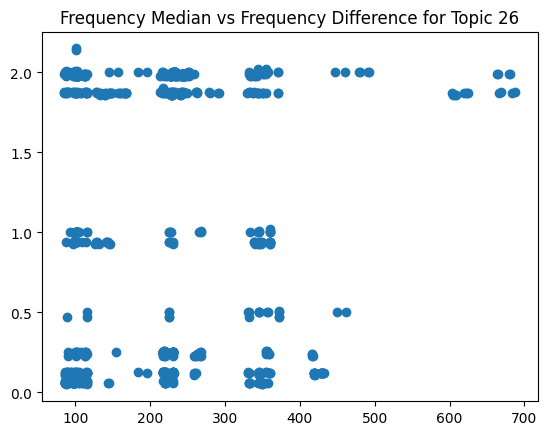

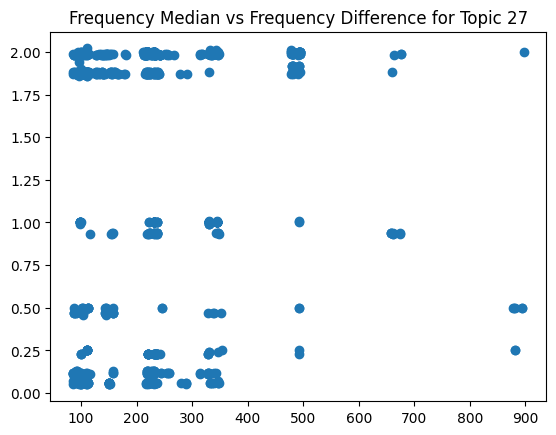

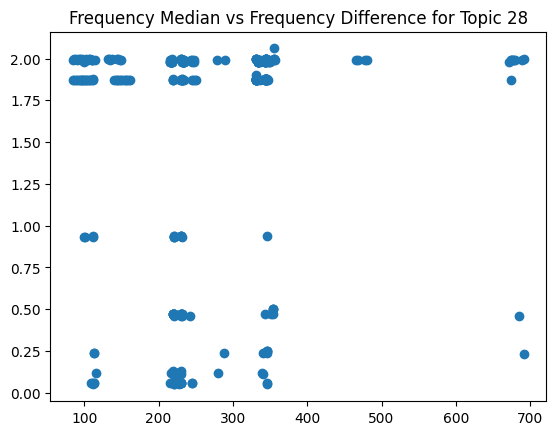

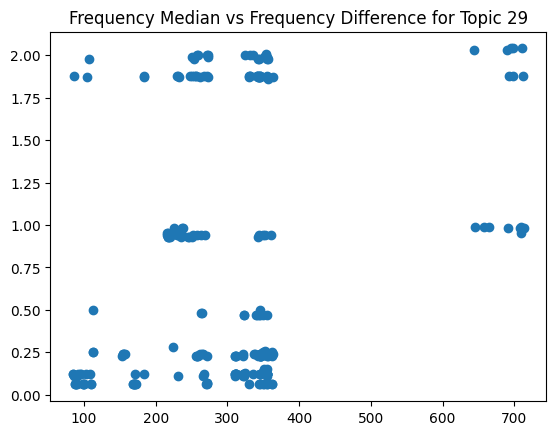

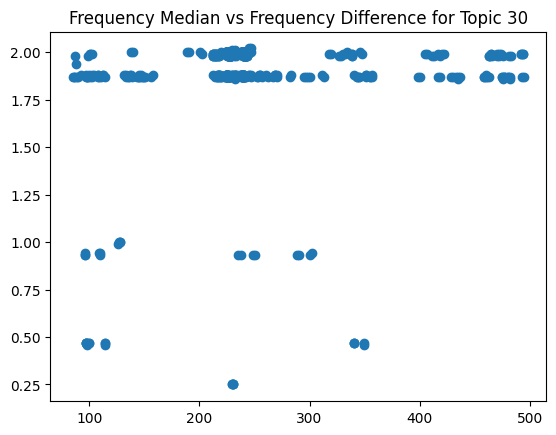

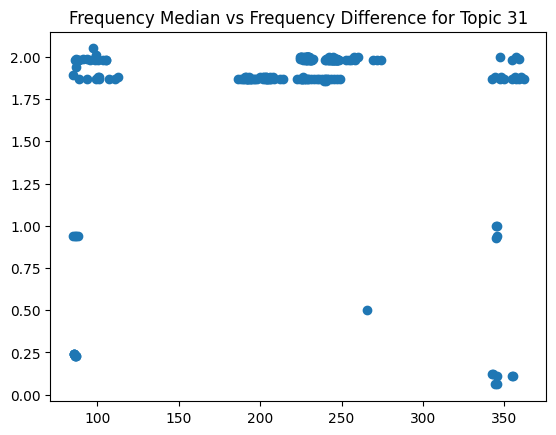

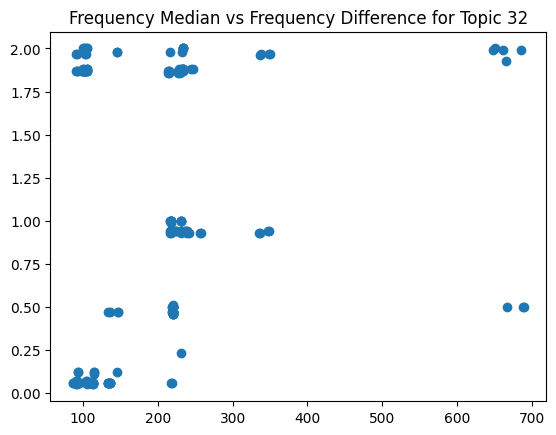

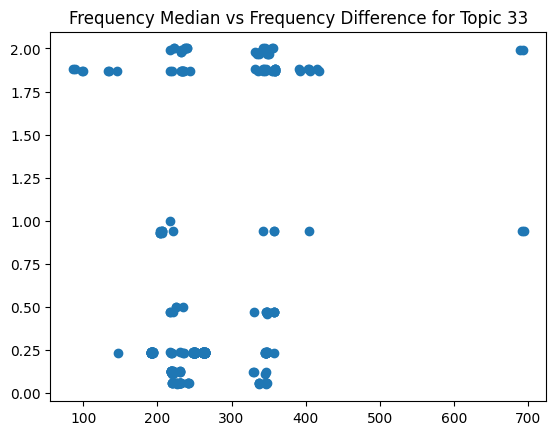

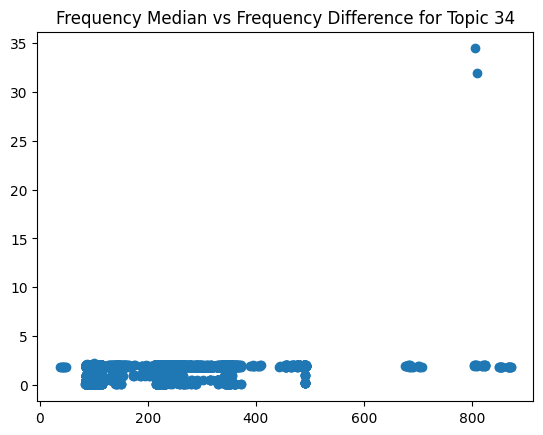

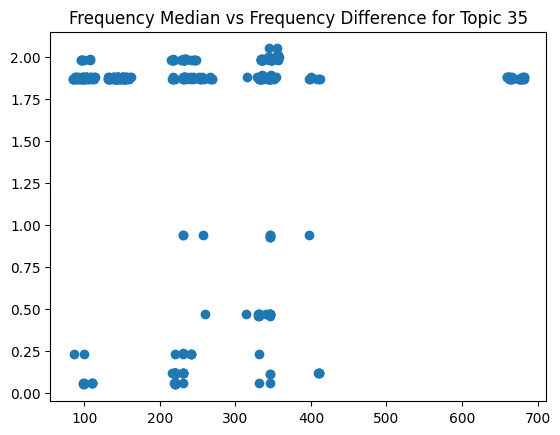

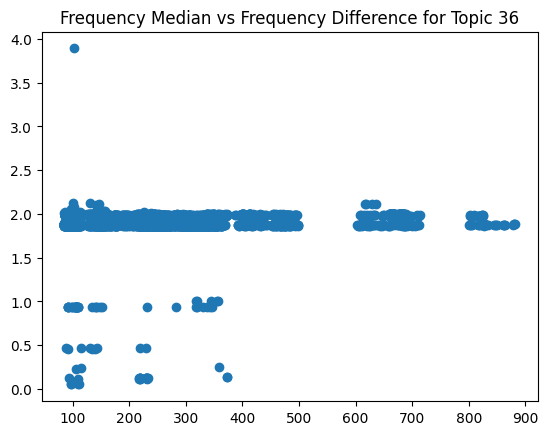

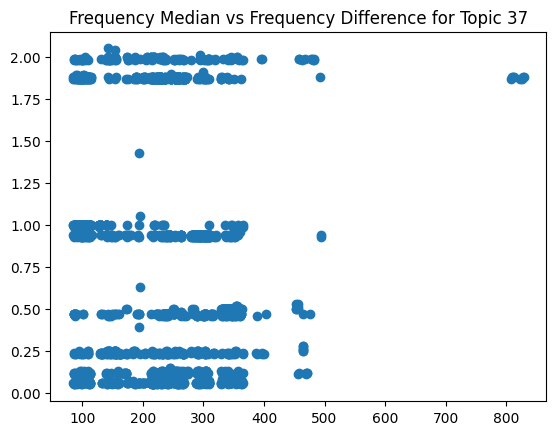

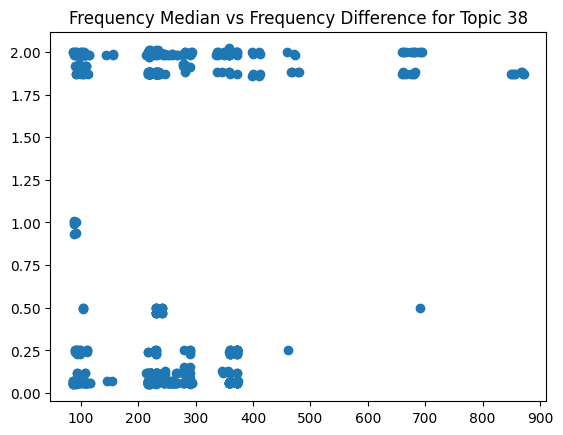

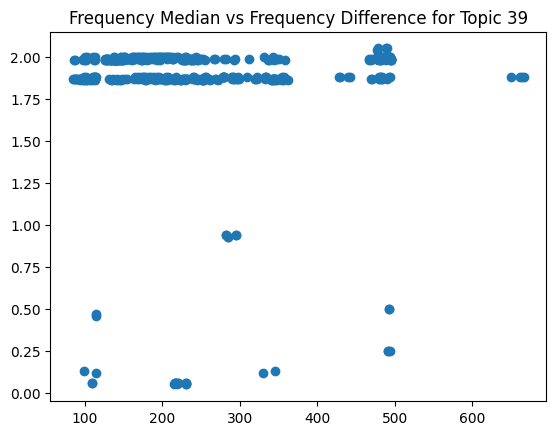

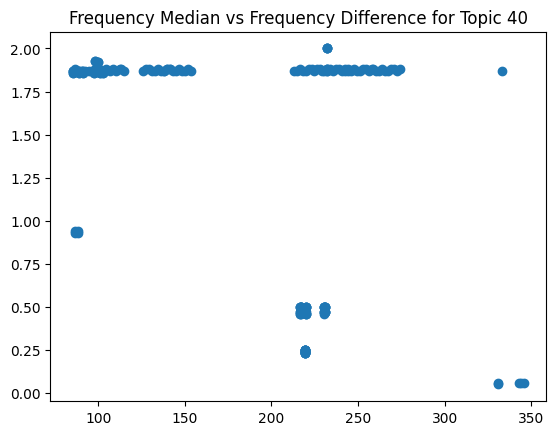

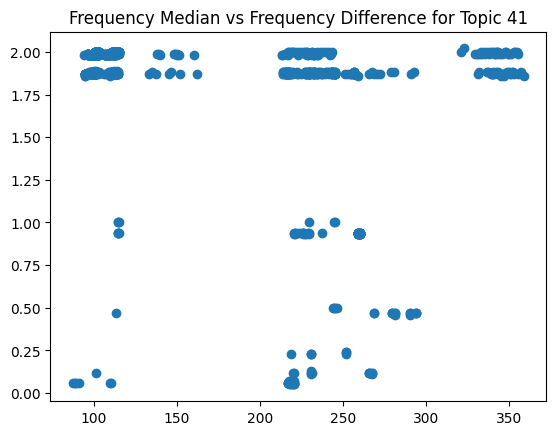

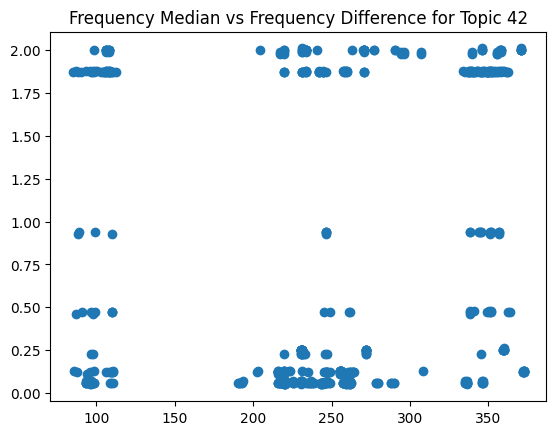

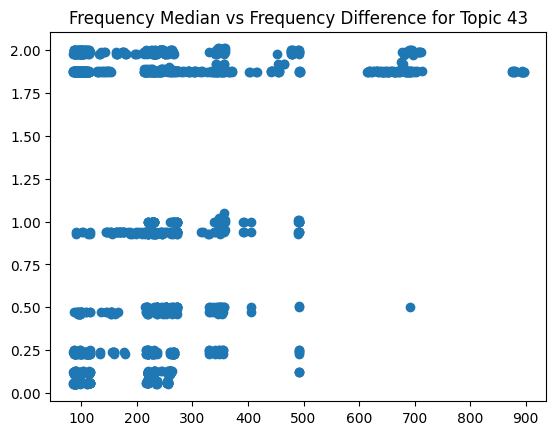

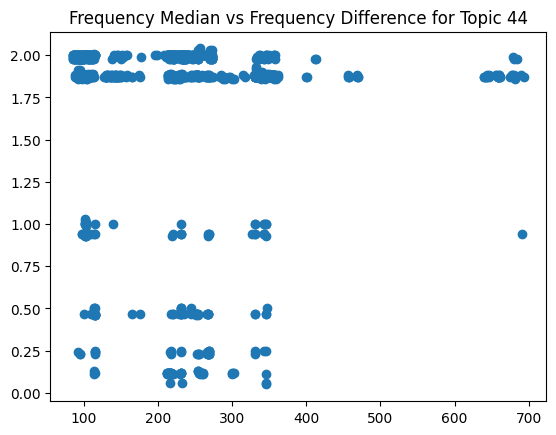

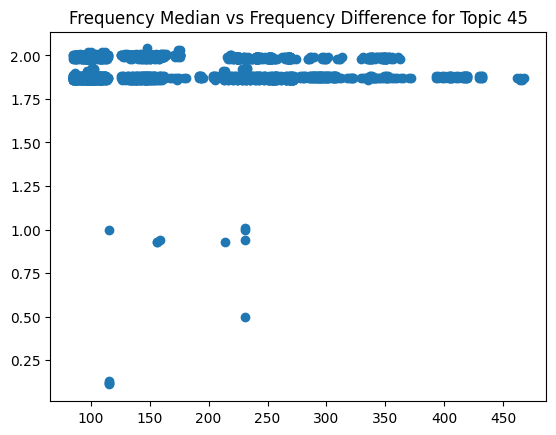

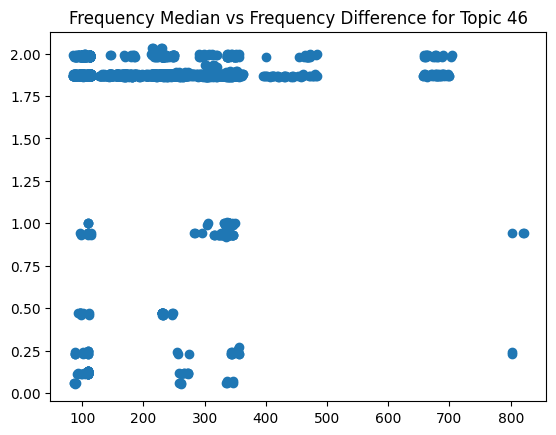

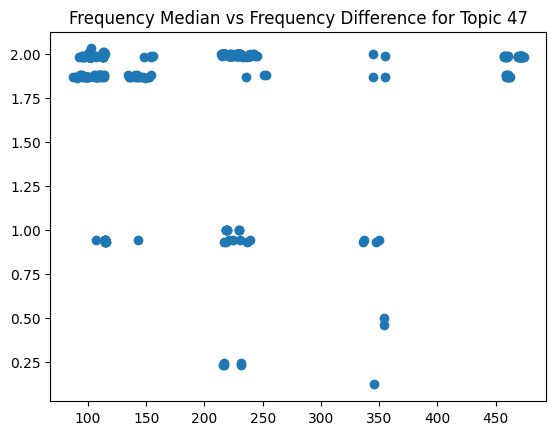

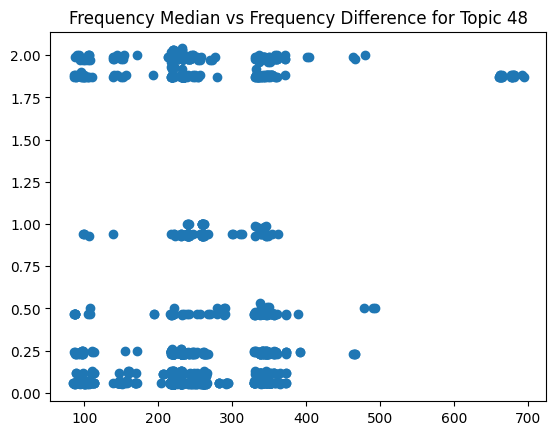

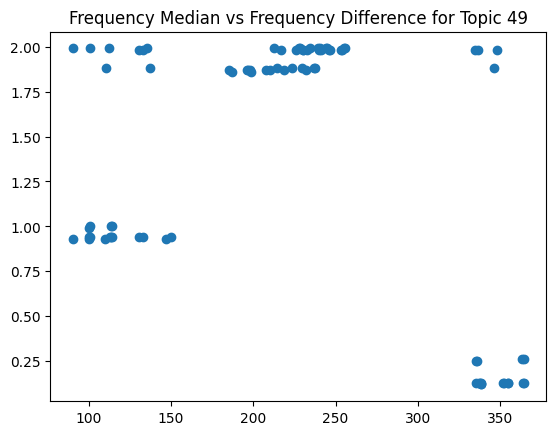

In [53]:
for topic in np.sort(proj_max_topic.max_topic.unique()):
    plt.figure()
    plt.title(f'Frequency Median vs Frequency Difference for Topic {topic}')
    plt.scatter(x=measurements.loc[list(proj_max_topic[proj_max_topic.max_topic == topic].index)].med_freq,
                y=measurements.loc[list(proj_max_topic[proj_max_topic.max_topic == topic].index)].diff_freq)

What if for each topic, we simply cluster frequency measurements using DBSCAN?

Create topic-project data frame

Add frequency measurements to `proj_max_topic`

In [54]:
proj_max_topic = proj_max_topic.join(proj_measurements[['lh_freq', 'dm_freq']])
proj_max_topic

,max_topic,lh_freq,dm_freq
2017.1.00065.S,34,"[(343.49, 345.4)]","[(1.91, 344.445)]"
2013.1.00530.S,36,"[(84.53, 86.41), (84.54, 86.41), (86.41, 88.28...","[(1.87, 94.445), (1.87, 96.325), (1.87, 106.44..."
2016.1.00243.S,34,"[(216.95, 218.83), (219.04, 220.91), (231.15, ...","[(1.88, 217.89), (1.87, 219.975), (1.87, 232.0..."
2021.2.00056.S,0,"[(86.18, 86.77), (86.71, 87.18), (88.58, 88.65...","[(0.06, 90.64), (0.06, 93.15), (2.0, 103.22), ..."
2021.1.00347.S,23,"[(212.69, 214.56), (215.93, 217.8), (221.74, 2...","[(1.87, 213.625), (1.87, 216.865), (1.87, 230...."
...,...,...,...
2017.1.01568.S,36,"[(109.95, 111.83)]","[(1.88, 110.89)]"
2021.1.00520.S,24,"[(329.09, 329.56), (330.34, 330.81), (330.35, ...","[(0.47, 329.325), (0.46, 330.58), (1.88, 331.7..."
2016.1.01135.S,11,"[(343.33, 345.21), (345.14, 347.01)]","[(1.88, 344.27), (1.87, 346.075)]"
2018.1.00452.S,37,"[(212.75, 212.86), (212.97, 213.09), (213.23, ...","[(0.11, 218.535), (0.23, 218.975), (0.11, 219...."


In [55]:
train_topic_projects = proj_max_topic.loc[list(train_texts.index.values)]
train_topic_projects = train_topic_projects.reset_index()
train_topic_projects = train_topic_projects.groupby(['max_topic', 'index'])\
    .agg({
        'lh_freq': lambda x: x,
        'dm_freq': lambda x: x
    })
train_topic_projects.index.names = ['max_topic', 'project_code']
train_topic_projects

lh_freq  \
max_topic project_code                                                        
0         2011.0.00059.S  [(673.5, 674.44), (675.5, 676.43), (688.49, 68...   
          2011.0.00429.S  [(215.62, 217.49), (218.08, 219.95), (230.19, ...   
          2011.0.00474.S  [(90.62, 90.74), (93.14, 93.25), (103.99, 104....   
          2011.0.00647.S  [(333.76, 335.63), (335.59, 337.47), (345.56, ...   
          2011.0.00656.S  [(228.75, 228.98), (231.17, 231.41), (241.54, ...   
...                                                                     ...   
49        2016.2.00164.S  [(335.39, 335.63), (335.5, 335.64), (335.97, 3...   
          2017.1.00027.S  [(222.77, 224.65), (231.33, 233.2), (236.17, 2...   
          2017.1.01018.S  [(184.07, 185.94), (185.95, 187.81), (195.0, 1...   
          2019.1.00678.S  [(90.3, 91.23), (99.68, 100.62), (109.44, 110....   
          2021.1.00898.S  [(99.51, 100.47), (99.54, 100.5), (100.44, 101...   

                                                                    dm_freq  
max_topic project_code                                                       
0         2011.0.00059.S  [(0.94, 673.97), (0.93, 675.965), (0.94, 688.9...  
          2011.0.00429.S  [(1.87, 216.555), (1.87, 219.015), (1.87, 231....  
          2011.0.00474.S  [(0.12, 90.68), (0.11, 93.195), (0.12, 104.05)...  
          2011.0.00647.S  [(0.94, 691.47), (0.94, 694.05), (0.94, 708.8)...  
          2011.0.00656.S  [(0.23, 228.865), (0.24, 231.29), (0.24, 241.6...  
...                                                                     ...  
49        2016.2.00164.S  [(0.25, 335.515), (0.13, 335.565), (0.25, 336....  
          2017.1.00027.S  [(1.87, 232.265), (1.88, 237.11), (1.88, 223.7...  
          2017.1.01018.S  [(1.87, 195.935), (1.87, 197.805), (1.87, 208....  
          2019.1.00678.S  [(1.88, 110.38), (0.93, 109.965), (0.94, 112.7...  
          2021.1.00898.S  [(0.99, 100.005), (1.0, 100.94), (1.0, 113.26)...  

[2721 rows x 2 columns]

Combine frequency columns into `max_topic`

In [56]:
train_measurements = measurements.loc[list(train_texts.index.values)]
train_measurements = train_measurements.join(proj_max_topic.loc[list(train_texts.index.values)])
train_measurements.head()

,project_title,project_abstract,fs_type,low_freq,high_freq,target,diff_freq,med_freq,raw_text,standardized_text,no_sw_text,lemmatized_sw_text,lemmatized_no_sw_text,max_topic,lh_freq,dm_freq
project_code,,,,,,,,,,,,,,,,
2011.0.00020.S,Molecular line flux ratios and AGN feedback in...,We propose multiple submillimeter molecular li...,line,334.61,336.50,1,1.89,335.555,Molecular line flux ratios and AGN feedback in...,molecular line flux ratios and agn feedback in...,molecular line flux ratios agn feedback gas du...,molecular line flux ratio and agn feedback in ...,molecular line flux ratio agn feedback gas dus...,46,"[(251.53, 253.42), (253.41, 255.29), (257.24, ...","[(1.89, 335.555), (1.89, 347.665), (1.88, 329...."
2011.0.00020.S,Molecular line flux ratios and AGN feedback in...,We propose multiple submillimeter molecular li...,line,346.72,348.61,1,1.89,347.665,Molecular line flux ratios and AGN feedback in...,molecular line flux ratios and agn feedback in...,molecular line flux ratios agn feedback gas du...,molecular line flux ratio and agn feedback in ...,molecular line flux ratio agn feedback gas dus...,46,"[(251.53, 253.42), (253.41, 255.29), (257.24, ...","[(1.89, 335.555), (1.89, 347.665), (1.88, 329...."
2011.0.00020.S,Molecular line flux ratios and AGN feedback in...,We propose multiple submillimeter molecular li...,line,328.56,330.44,1,1.88,329.500,Molecular line flux ratios and AGN feedback in...,molecular line flux ratios and agn feedback in...,molecular line flux ratios agn feedback gas du...,molecular line flux ratio and agn feedback in ...,molecular line flux ratio agn feedback gas dus...,46,"[(251.53, 253.42), (253.41, 255.29), (257.24, ...","[(1.89, 335.555), (1.89, 347.665), (1.88, 329...."
2011.0.00020.S,Molecular line flux ratios and AGN feedback in...,We propose multiple submillimeter molecular li...,line,330.44,332.32,1,1.88,331.380,Molecular line flux ratios and AGN feedback in...,molecular line flux ratios and agn feedback in...,molecular line flux ratios agn feedback gas du...,molecular line flux ratio and agn feedback in ...,molecular line flux ratio agn feedback gas dus...,46,"[(251.53, 253.42), (253.41, 255.29), (257.24, ...","[(1.89, 335.555), (1.89, 347.665), (1.88, 329...."
2011.0.00020.S,Molecular line flux ratios and AGN feedback in...,We propose multiple submillimeter molecular li...,line,340.63,342.51,1,1.88,341.570,Molecular line flux ratios and AGN feedback in...,molecular line flux ratios and agn feedback in...,molecular line flux ratios agn feedback gas du...,molecular line flux ratio and agn feedback in ...,molecular line flux ratio agn feedback gas dus...,46,"[(251.53, 253.42), (253.41, 255.29), (257.24, ...","[(1.89, 335.555), (1.89, 347.665), (1.88, 329...."


In [57]:
max_topic_train_freqs = train_measurements.groupby('max_topic')\
    .agg({
        'low_freq': lambda x: round(x, 4).tolist(),
        'high_freq': lambda x: round(x, 4).tolist(),
        'med_freq': lambda x: round(x, 4).tolist(),
        'diff_freq': lambda x: round(x, 4).tolist()
    })
max_topic_train_freqs

,low_freq,high_freq,med_freq,diff_freq
max_topic,,,,
0,"[673.5, 675.5, 688.49, 690.98, 215.62, 218.08,...","[674.44, 676.43, 689.43, 691.92, 217.49, 219.9...","[673.97, 675.965, 688.96, 691.45, 216.555, 219...","[0.94, 0.93, 0.94, 0.94, 1.87, 1.87, 1.87, 1.8..."
1,"[642.68, 645.5, 657.07, 660.14, 130.65, 132.53...","[644.56, 647.37, 658.95, 662.01, 132.52, 134.4...","[643.62, 646.435, 658.01, 661.075, 131.585, 13...","[1.88, 1.87, 1.88, 1.87, 1.87, 1.87, 1.87, 1.8..."
2,"[341.0, 342.59, 352.63, 354.34, 85.4, 87.23, 9...","[342.88, 344.46, 354.5, 356.21, 87.28, 89.11, ...","[341.94, 343.525, 353.565, 355.275, 86.34, 88....","[1.88, 1.87, 1.87, 1.87, 1.88, 1.88, 1.88, 1.8..."
3,"[342.36, 344.24, 354.28, 355.79, 342.36, 100.0...","[344.23, 346.11, 356.16, 357.66, 344.24, 101.9...","[343.295, 345.175, 355.22, 356.725, 343.3, 100...","[1.87, 1.87, 1.88, 1.87, 1.88, 1.93, 1.92, 1.9..."
4,"[84.96, 88.25, 97.35, 98.82, 89.51, 91.44, 101...","[86.83, 88.72, 98.28, 100.8, 91.49, 93.43, 103...","[85.895, 88.485, 97.815, 99.81, 90.5, 92.435, ...","[1.87, 0.47, 0.93, 1.98, 1.98, 1.99, 1.98, 1.9..."
5,"[84.41, 86.17, 96.67, 98.37, 227.6, 229.6, 241...","[86.3, 88.06, 98.56, 100.26, 229.47, 231.47, 2...","[85.355, 87.115, 97.615, 99.315, 228.535, 230....","[1.89, 1.89, 1.89, 1.89, 1.87, 1.87, 1.87, 1.8..."
6,"[99.91, 101.78, 111.91, 113.86, 85.69, 87.52, ...","[101.79, 103.66, 113.79, 115.74, 87.57, 89.4, ...","[100.85, 102.72, 112.85, 114.8, 86.63, 88.46, ...","[1.88, 1.88, 1.88, 1.88, 1.88, 1.88, 1.87, 1.8..."
7,"[639.15, 645.41, 657.7, 661.7, 320.98, 322.12,...","[640.11, 646.37, 658.66, 662.66, 321.46, 322.6...","[639.63, 645.89, 658.18, 662.18, 321.22, 322.3...","[0.96, 0.96, 0.96, 0.96, 0.48, 0.48, 0.49, 0.4..."
8,"[333.75, 335.36, 345.74, 347.36, 100.5, 112.44...","[333.85, 335.46, 345.84, 347.46, 102.49, 114.4...","[333.8, 335.41, 345.79, 347.41, 101.495, 113.4...","[0.1, 0.1, 0.1, 0.1, 1.99, 1.99, 1.0, 1.87, 1...."


In [58]:
list(zip(max_topic_train_freqs.loc[47].med_freq, max_topic_train_freqs.loc[47].diff_freq))

[(216.115, 0.23),
 (217.175, 0.23),
 (231.22, 0.24),
 (231.345, 0.23),
 (217.18, 0.24),
 (220.79, 0.94),
 (224.67, 0.94),
 (236.905, 0.93),
 (239.11, 0.94),
 (336.045, 0.93),
 (336.82, 0.94),
 (347.285, 0.93),
 (349.41, 0.94),
 (216.935, 0.93),
 (218.305, 0.93),
 (230.36, 0.94),
 (142.74, 0.94),
 (96.595, 1.99),
 (107.06, 0.94),
 (93.28, 1.88),
 (95.115, 1.87),
 (105.28, 1.88),
 (106.925, 1.87),
 (96.925, 1.87),
 (98.845, 1.87),
 (109.16, 1.88),
 (110.865, 1.87),
 (97.175, 1.87),
 (99.095, 1.87),
 (109.43, 1.88),
 (111.16, 1.88),
 (92.92, 1.88),
 (94.75, 1.88),
 (104.865, 1.87),
 (106.505, 1.87),
 (97.465, 1.87),
 (99.285, 1.87),
 (109.655, 1.87),
 (111.39, 1.88),
 (98.395, 1.87),
 (100.135, 1.87),
 (110.59, 1.88),
 (112.325, 1.87),
 (99.8, 1.98),
 (101.675, 1.99),
 (111.8, 1.98),
 (113.675, 1.87),
 (99.605, 1.99),
 (101.48, 1.98),
 (111.605, 1.99),
 (113.48, 1.88),
 (99.595, 1.99),
 (101.47, 1.98),
 (111.595, 1.99),
 (113.47, 1.88),
 (101.005, 2.01),
 (102.955, 2.03),
 (113.505, 2.01)

In [170]:
inspect_topic = 30

In [249]:
#db = DBSCAN(eps=3, min_samples=19).fit(list(zip(max_topic_train_freqs.loc[47].med_freq, max_topic_train_freqs.loc[47].diff_freq)))
#db = DBSCAN(eps=0.3, min_samples=5).fit(list(zip(max_topic_train_freqs.loc[inspect_topic].med_freq))) # 13 is interesting
db = DBSCAN(eps=10, min_samples=10).fit(list(zip(max_topic_train_freqs.loc[inspect_topic].med_freq)))

In [250]:
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 5
Estimated number of noise points: 31


In [251]:
print(f'Signal to noise ratio: {round(list(labels).count(-1)/labels.shape[0], 3)}')

Signal to noise ratio: 0.073


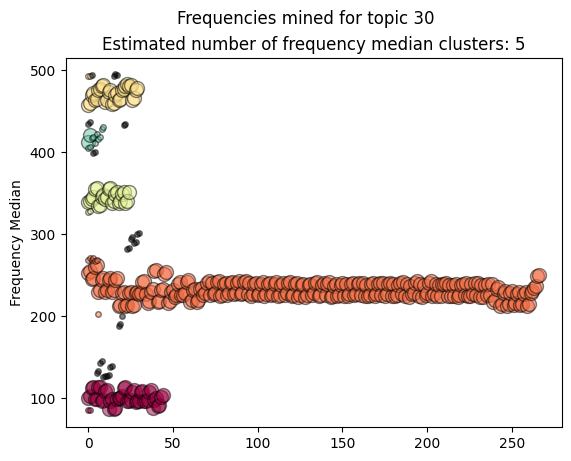

In [252]:
import matplotlib.pyplot as plt
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

#X = np.array(list(zip(max_topic_train_freqs.loc[47].med_freq, max_topic_train_freqs.loc[47].diff_freq)))
X = np.array(list(zip(max_topic_train_freqs.loc[inspect_topic].med_freq)))

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        #xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=10,
        alpha=0.5
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        #xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=4,
        alpha=0.5
    )

plt.title(f"Estimated number of frequency median clusters: {n_clusters_}")
plt.ylabel('Frequency Median')
plt.suptitle(f"Frequencies mined for topic {inspect_topic}")
plt.show()

Inspect measurements for this max topic to see if their number of measurements is similar to the number of clusters

In [253]:
train_measurements.query('max_topic == 30')\
    .groupby(train_measurements.query('max_topic == 30').index.values)\
    .count().describe()

,project_title,project_abstract,fs_type,low_freq,high_freq,target,diff_freq,med_freq,raw_text,standardized_text,no_sw_text,lemmatized_sw_text,lemmatized_no_sw_text,max_topic,lh_freq,dm_freq
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,14.586207,14.586207,14.586207,14.586207,14.586207,14.586207,14.586207,14.586207,14.586207,14.586207,14.586207,14.586207,14.586207,14.586207,14.586207,14.586207
std,28.739616,28.739616,28.739616,28.739616,28.739616,28.739616,28.739616,28.739616,28.739616,28.739616,28.739616,28.739616,28.739616,28.739616,28.739616,28.739616
min,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
25%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
50%,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
75%,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
max,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000


Assign labels to measurements for topic and find cluster centers

In [254]:
pd.Series(labels)

0      0
1      0
2      0
3      0
4      1
      ..
418    1
419   -1
420   -1
421   -1
422   -1
Length: 423, dtype: int64

In [255]:
topic_47 = pd.DataFrame(max_topic_train_freqs.loc[30].med_freq, max_topic_train_freqs.loc[30].diff_freq)\
    .reset_index()
topic_47.columns = ['diff_freq', 'med_freq']
topic_47['cluster_freq'] = pd.Series(labels)
topic_47

,diff_freq,med_freq,cluster_freq
0,1.87,100.585,0
1,1.88,102.420,0
2,1.88,112.460,0
3,1.87,114.295,0
4,1.87,253.285,1
...,...,...,...
418,0.93,250.395,1
419,0.93,289.005,-1
420,0.93,290.905,-1
421,0.93,300.405,-1


In [256]:
topic_47.groupby('cluster_freq').mean()

,diff_freq,med_freq
cluster_freq,,
-1,1.666129,283.020484
0,1.438298,100.578723
1,1.900693,232.802062
2,1.926875,472.375938
3,1.655556,343.913704
4,1.947500,417.457917


In [257]:
test_max_topic = test_doc_topic.idxmax(axis=1).to_frame()
test_max_topic.columns = ['max_topic']
test_max_topic.query('max_topic == 30')

,max_topic
2015.1.00939.S,30
2016.2.00115.S,30
2018.1.01750.S,30
2013.1.00861.S,30


In [258]:
proj_measurements.loc[test_max_topic.query('max_topic == 30').index.values]

,low_freq,high_freq,diff_freq,med_freq,lh_freq,dm_freq,max_topic
project_code,,,,,,,
2015.1.00939.S,"[132.63, 134.46, 134.71, 135.74, 136.54, 137.5...","[134.5, 136.33, 136.58, 137.62, 138.42, 139.45...","[1.88, 1.87, 1.88, 1.87, 1.87, 1.87, 1.87, 1.8...","[217.0, 218.875, 232.63, 234.505, 143.795, 145...","[(132.63, 134.5), (134.46, 136.33), (134.71, 1...","[(1.88, 217.0), (1.87, 218.875), (1.88, 232.63...",30
2016.2.00115.S,"[218.9, 220.51, 233.01, 234.71, 316.91, 318.61...","[220.9, 222.5, 235.0, 236.7, 318.9, 320.6, 331...","[2.0, 1.99, 1.99, 1.99, 1.99, 1.99, 1.99, 1.99]","[219.9, 221.505, 234.005, 235.705, 317.905, 31...","[(218.9, 220.9), (220.51, 222.5), (233.01, 235...","[(2.0, 219.9), (1.99, 221.505), (1.99, 234.005...",30
2018.1.01750.S,[227.61],[229.49],[1.88],[228.55],"[(227.61, 229.49)]","[(1.88, 228.55)]",30
2013.1.00861.S,[229.19],[231.06],[1.87],[230.125],"[(229.19, 231.06)]","[(1.87, 230.125)]",30


In [260]:
len(proj_measurements.loc['2015.1.00939.S'].med_freq)

40